# Bio-indicators of climate

## Imports

In [1]:
from statistics import *
from visualization import *
from empirical_model import *
from linear_regression_model import *
from occupancy_detection_model import *
from scipy.special import expit

## Data generation

In [2]:
# Covariables
cA, cB = np.random.uniform(-np.sqrt(3), np.sqrt(3), 10000), np.random.uniform(-np.sqrt(3), np.sqrt(3), 10000)

# Probabilities of occupancy
psis = np.array([expit(1 + 3 * cA), expit(cA)])  # Steep, gentle

psis = np.tile(psis[:, np.newaxis, :], (1, 4, 1))

# Conditional probabilities of detection
ps = np.array([len(cA) * [0.5], expit(cA), expit(-cA), expit(cB)])  # Constant, positive, negative, independent
ps = np.tile(ps[np.newaxis, :, :], (2, 1, 1))

# Probabilities of detection, with 1 trial
print(psis.shape, ps.shape)
ds = ps * psis

# Probabilities of detection with K trials
K = 2 # K trials per site
psk = 1 - (1 - ps) ** K
dsk = psk * psis

labels = np.array([["Steep, constant", "Steep, positive", "Steep, negative", "Steep, independent"], 
                   ["Gentle, constant", "Gentle, positive", "Gentle, negative", "Gentle, independent"]])

(2, 4, 10000) (2, 4, 10000)


In [3]:
occupancy_labels = np.random.binomial(1, psis) # Binary draw for occupancy
print(occupancy_labels)
number_detections = np.random.binomial(K, occupancy_labels * ds) # Binary draw for detection
binary_detections = 1 * (number_detections != 0)
print(binary_detections)

[[[0 0 1 ... 1 1 1]
  [0 0 1 ... 1 1 1]
  [1 0 1 ... 1 1 1]
  [0 0 1 ... 1 0 1]]

 [[0 0 1 ... 0 1 1]
  [1 0 0 ... 1 0 1]
  [0 0 1 ... 1 1 1]
  [0 0 0 ... 1 0 1]]]
[[[0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 1 ... 1 0 0]
  [0 0 1 ... 1 0 0]]

 [[0 0 0 ... 0 0 1]
  [0 0 0 ... 0 0 1]
  [0 0 1 ... 1 1 0]
  [0 0 0 ... 1 0 1]]]


## Plotting the 8 scenarios

2 occupancy-environment relationships and 4 detection-environment relationships.

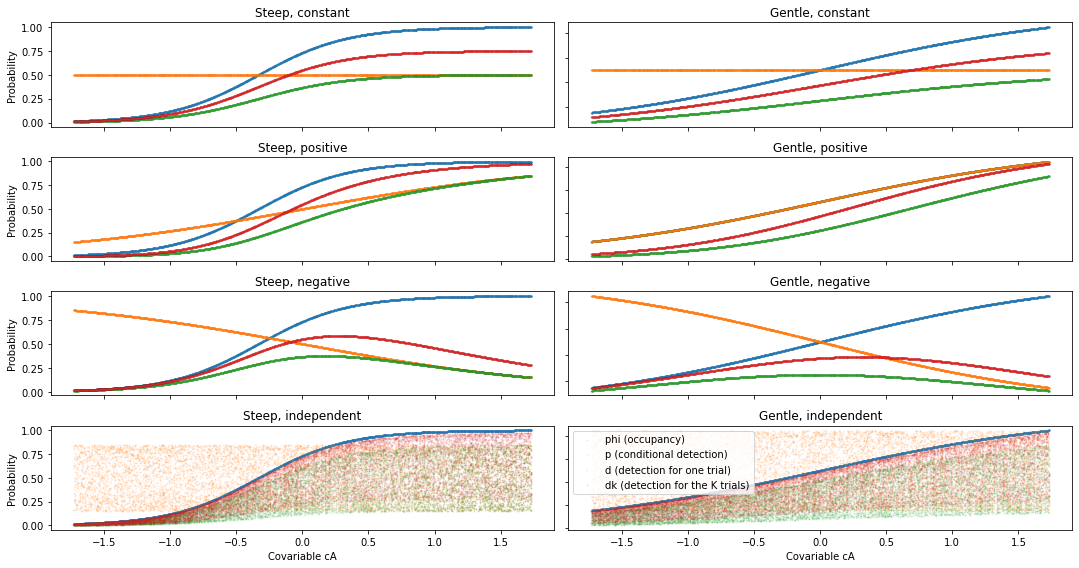

In [4]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, axs = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        axs[i, j].scatter(cA, psis[j, i], s=1, label="phi (occupancy)", alpha=0.1)
        axs[i, j].scatter(cA, ps[j, i], s=1, label="p (conditional detection)", alpha=0.1)
        axs[i, j].scatter(cA, ds[j, i], s=1, label="d (detection for one trial)", alpha=0.1)
        axs[i, j].scatter(cA, dsk[j, i], s=1, label="dk (detection for the K trials)", alpha=0.1)
        axs[i, j].set_title(labels[j, i])

for ax in axs.flat:
    ax.set(xlabel='Covariable cA', ylabel='Probability')
    ax.label_outer()
    
fig.tight_layout()
plt.legend()
plt.show()

## Model fitting and prediction

In [5]:
plt.rcParams['figure.figsize'] = (15, 3)
glm_models = [[], []]
empirical_models = [[], []]
od_models = [[], []]
for i in range(2):
    for j in range(4):
        occupancy_label = occupancy_labels[i, j]
        binary_detection = binary_detections[i, j]
        number_detection = number_detections[i, j]
        p = np.random.permutation(len(occupancy_label))
        binary_detection_train, occupancy_label_train = binary_detection[p][: 400], occupancy_label[p][: 400]
        number_detection_train = number_detection[p][: 400]
        cA_train, cB_train = cA[p][: 400], cB[p][: 400]
        binary_detection_test, occupancy_label_test = binary_detection[p][400:], occupancy_label[p][400:]
        number_detection_test = number_detection[p][400: ]
        cA_test, cB_test = cA[p][400 : ], cB[p][400 : ]
        
        model = Linear_Regression_Model()
        if j < 3:
            model.fit((cA_train, cA_train ** 2), binary_detection_train)
            proba_detection_predict = model.predict_proba((cA_test, cA_test ** 2))
            detection_predict = model.predict((cA_test, cA_test ** 2))
        else:
            model.fit((cA_train, cB_train, cA_train ** 2, cB_train ** 2, cA_train * cB_train), binary_detection_train)
            proba_detection_predict = model.predict_proba((cA_test, cB_test, cA_test ** 2, cB_test ** 2, cA_test * cB_test))
            detection_predict = model.predict((cA_test, cB_test, cA_test ** 2, cB_test ** 2, cA_test * cB_test))
        glm_models[i].append(model)

        # Plot the ROC curve
        #Visualization.plot_roc(detection_test, proba_detection_predict, title='ROC curve for the scenario: ' + labels[i, j])
        
        model = Empirical_Model()
        if j < 3:
            model.fit((cA_train, cA_train ** 2), binary_detection_train)
            proba_detection_predict = model.predict_proba((cA_test, cA_test ** 2))
        else:
            model.fit((cA_train, cB_train, cA_train ** 2, cB_train ** 2, cA_train * cB_train), binary_detection_train)
            proba_detection_predict = model.predict_proba((cA_test, cB_test, cA_test ** 2, cB_test ** 2, cA_test * cB_test))
        empirical_models[i].append(model)
        
        if j < 3:
            model = Occupancy_Detection_Model((cA_train, cA_train ** 2), number_detection_train, K=K)
            model.fit()
        else:
            model = Occupancy_Detection_Model((cA_train, cB_train, cA_train ** 2,
                                               cB_train ** 2, cA_train * cB_train), number_detection_train, K=2)
            model.fit()
        od_models[i].append(model)

Optimization terminated successfully.
         Current function value: 0.828000
         Iterations: 727
         Function evaluations: 1122


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


Optimization terminated successfully.
         Current function value: 0.784657
         Iterations: 1071
         Function evaluations: 1658
Optimization terminated successfully.
         Current function value: 0.768209
         Iterations: 498
         Function evaluations: 792
Optimization terminated successfully.
         Current function value: 0.778643
         Iterations: 3460
         Function evaluations: 4735
Optimization terminated successfully.
         Current function value: 0.706597
         Iterations: 770
         Function evaluations: 1199
Optimization terminated successfully.
         Current function value: 0.745553
         Iterations: 568
         Function evaluations: 864


C:\Users\XAVIER\Documents\Stage\SDM\occupancy_detection_model.py:29: RuntimeWarning: divide by zero encountered in log
  ll_non_null = np.log(occupancy) + self.endog * np.log(detection) + (self.K - self.endog) * np.log(1 - detection)
C:\Users\XAVIER\Documents\Stage\SDM\occupancy_detection_model.py:34: RuntimeWarning: invalid value encountered in multiply
  ll  = (self.endog != 0) * ll_non_null + (self.endog == 0) * ll_null


Optimization terminated successfully.
         Current function value: 0.598531
         Iterations: 1835
         Function evaluations: 2824


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\miniconda\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\miniconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Results in the environmental space

For the 'steep, independent' scenario, that is: the probability of occupancy depends on cA and the conditional probability of detection depends on cB.

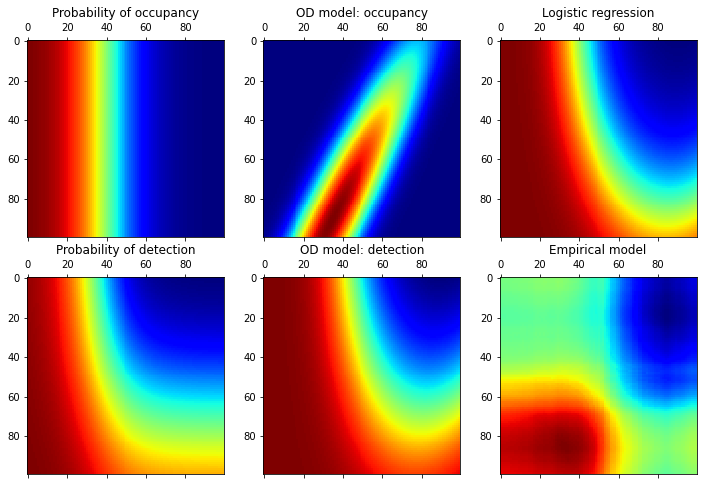

In [6]:
cA_grid, cB_grid = np.linspace(-np.sqrt(3), np.sqrt(3), 100), np.linspace(-np.sqrt(3), np.sqrt(3), 100)
cB_grid = np.flip(cB_grid)
cA_grid, cB_grid = np.meshgrid(cA_grid, cB_grid)
od_model = od_models[0][3]
glm_model = glm_models[0][3]
empirical_model = empirical_models[0][3]

plt.rcParams['figure.figsize'] = (12, 8)
fig, axs = plt.subplots(2, 3)

phi_grid = expit(1 + 3 * cA_grid)
axs[0, 0].matshow(phi_grid, cmap='jet_r')
axs[0, 0].set_title('Probability of occupancy')

p_grid = expit(cB_grid)
d_grid = p_grid * phi_grid
dk_grid = 1 - (1 - d_grid) ** K
axs[1, 0].matshow(dk_grid, cmap='jet_r')
axs[1, 0].set_title('Probability of detection')

od_occupancy, od_detection = od_model.predict((np.ravel(cA_grid), np.ravel(cB_grid), np.ravel(cA_grid) ** 2,
                                                np.ravel(cB_grid) ** 2, np.ravel(cA_grid) * np.ravel(cB_grid)))
od_occupancy, od_detection = od_occupancy.reshape(cA_grid.shape), od_detection.reshape(cA_grid.shape)
axs[0, 1].matshow(od_occupancy, cmap='jet_r')
axs[0, 1].set_title('OD model: occupancy')
axs[1, 1].matshow(od_detection, cmap='jet_r')
axs[1, 1].set_title('OD model: detection')

glm_prediction = glm_model.predict_proba((np.ravel(cA_grid), np.ravel(cB_grid), np.ravel(cA_grid) ** 2,
                                      np.ravel(cB_grid) ** 2, np.ravel(cA_grid) * np.ravel(cB_grid)))
glm_prediction = glm_prediction.reshape(cA_grid.shape)
axs[0, 2].matshow(glm_prediction, cmap='jet_r')
axs[0, 2].set_title('Logistic regression')

empirical_model_prediction = empirical_model.predict_proba((np.ravel(cA_grid), np.ravel(cB_grid), np.ravel(cA_grid) ** 2,
                                      np.ravel(cB_grid) ** 2, np.ravel(cA_grid) * np.ravel(cB_grid)))
empirical_model_prediction = empirical_model_prediction.reshape(cA_grid.shape)
ax = axs[1, 2].matshow(empirical_model_prediction, cmap='jet_r')
axs[1, 2].set_title("Empirical model")

plt.show()

Discussion: the logistic regression fails to disentangle the crossed effect of occupancy (correlated with cA) and detection (correlated with cB).

In [7]:
x = ([2, 3, 2, 3, 2, 1, 0, -1], [7, 9, 10, 12, 11, 11, 11, 11])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1])
model = Occupancy_Detection_Model(x, y, K=2)
model.fit()

model.predict(([2, 3, 0], [7, 9, 10]))

Optimization terminated successfully.
         Current function value: 0.693173
         Iterations: 906
         Function evaluations: 1532


C:\miniconda\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(array([8.67791150e-150, 3.68568185e-074, 8.28890976e-014]),
 array([1.        , 0.99999999, 0.99989737]))